# Clip conversion pipeline

Get the clip.

Detect current court position. Store.

Detect current player positions. Store.

Based on current prediction and previous predictions calculate proper current position.

In [1]:
import matplotlib.animation as animation
import numpy as np
from pylab import *
from skimage.util import pad

%matplotlib inline
import tensorflow as tf
import os
import json
import subprocess
from scipy.misc import imread

from train import build_lstm_forward, build_overfeat_forward
from utils import googlenet_load, train_utils
from utils.annolist import AnnotationLib as al
from utils.stitch_wrapper import stitch_rects
from utils.train_utils import add_rectangles
import imageio
from skimage.util import pad, crop

import cv2
from matplotlib import pyplot as plt
from collections import deque

import court
import court_warp
import predict as pred

In [2]:
filename = 'data/test2.mp4'
vid = imageio.get_reader(filename, 'ffmpeg')

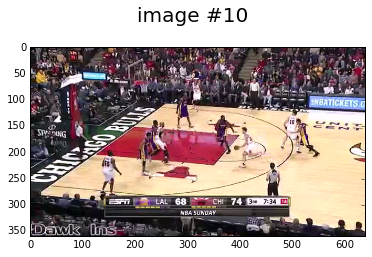

In [3]:
nums = [10,]
for num in nums:
    image = vid.get_data(num)
    fig = plt.figure()
    fig.suptitle('image #{}'.format(num), fontsize=20)
    plt.imshow(image)

In [4]:
lines = court_warp.get_all_lines(vid,cores=8)

In [5]:
points = court_warp.get_all_points(lines)

In [6]:
interped = court_warp.interpolate_points(points)

In [7]:
#hypes_file = './hypes/lstm.json'
hypes_file = './hypes/playertrackerlstm.json'

with open(hypes_file, 'r') as f:
    H = json.load(f)

tf.reset_default_graph()
googlenet = googlenet_load.init(H)
x_in = tf.placeholder(tf.float32, name='x_in')
if H['arch']['use_lstm']:
    pred_boxes, pred_logits, pred_confidences = build_lstm_forward(H, tf.expand_dims(x_in, 0), googlenet, 'test', reuse=None)
else:
    pred_boxes, pred_logits, pred_confidences = build_overfeat_forward(H, tf.expand_dims(x_in, 0), googlenet, 'test')

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.initialize_all_variables())
if H['arch']['use_lstm']:
    #saver.restore(sess, 'output/playertrackerlstm_2016_03_18_19.33/save.ckpt-3000')
    saver.restore(sess, 'output/save.ckpt-13000')
else:
    saver.restore(sess, 'output/playertracker_2016_03_18_14.12/save.ckpt-3000')

In [8]:
def predict(curr_image, conf=0.3):
    img = curr_image
    feed = {x_in: img}
    (np_pred_boxes, np_pred_confidences) = sess.run([pred_boxes, pred_confidences], feed_dict=feed)
#     print len(np_pred_boxes)
#     print np_pred_confidences[10]
    new_img, rects = add_rectangles([img], np_pred_confidences, np_pred_boxes,
                                    H["arch"], use_stitching=True, rnn_len=H['arch']['rnn_len'], min_conf=conf)

    return new_img, rects

In [9]:
from matplotlib.patches import Circle, Rectangle, Arc

# Function to draw the basketball court lines
def draw_court(ax=None, color="gray", lw=1, zorder=0):
    
    if ax is None:
        ax = plt.gca()

    # Creates the out of bounds lines around the court
    outer = Rectangle((0,-50), width=94, height=50, facecolor="#ffedc2",
                      zorder=zorder, fill=True, lw=lw)

    # The left and right basketball hoops
    l_hoop = Circle((5.35,-25), radius=.75, lw=lw, fill=False, 
                    color=color, zorder=zorder)
    r_hoop = Circle((88.65,-25), radius=.75, lw=lw, fill=False,
                    color=color, zorder=zorder)
    
    # Left and right backboards
    l_backboard = Rectangle((4,-28), 0, 6, lw=lw, color=color,
                            zorder=zorder)
    r_backboard = Rectangle((90, -28), 0, 6, lw=lw,color=color,
                            zorder=zorder)

    # Left and right paint areas
    l_outer_box = Rectangle((0, -33), 19, 16, lw=lw, fill=False,
                            color=color, zorder=zorder)    
    l_inner_box = Rectangle((0, -31), 19, 12, lw=lw, fill=False,
                            color=color, zorder=zorder)
    r_outer_box = Rectangle((75, -33), 19, 16, lw=lw, fill=False,
                            color=color, zorder=zorder)

    r_inner_box = Rectangle((75, -31), 19, 12, lw=lw, fill=False,
                            color=color, zorder=zorder)

    # Left and right free throw circles
    l_free_throw = Circle((19,-25), radius=6, lw=lw, fill=False,
                          color=color, zorder=zorder)
    r_free_throw = Circle((75, -25), radius=6, lw=lw, fill=False,
                          color=color, zorder=zorder)

    # Left and right corner 3-PT lines
    # a represents the top lines
    # b represents the bottom lines
    l_corner_a = Rectangle((0,-3), 14, 0, lw=lw, color=color,
                           zorder=zorder)
    l_corner_b = Rectangle((0,-47), 14, 0, lw=lw, color=color,
                           zorder=zorder)
    r_corner_a = Rectangle((80, -3), 14, 0, lw=lw, color=color,
                           zorder=zorder)
    r_corner_b = Rectangle((80, -47), 14, 0, lw=lw, color=color,
                           zorder=zorder)
    
    # Left and right 3-PT line arcs
    l_arc = Arc((5,-25), 47.5, 47.5, theta1=292, theta2=68, lw=lw,
                color=color, zorder=zorder)
    r_arc = Arc((89, -25), 47.5, 47.5, theta1=112, theta2=248, lw=lw,
                color=color, zorder=zorder)

    # half_court
    # ax.axvline(470)
    half_court = Rectangle((47,-50), 0, 50, lw=lw, color=color,
                           zorder=zorder)

    hc_big_circle = Circle((47, -25), radius=6, lw=lw, fill=False,
                           color=color, zorder=zorder, edgecolor=color)
    hc_sm_circle = Circle((47, -25), radius=2, lw=lw, fill=False,
                          color=color, zorder=zorder, edgecolor=color)

    court_elements = [outer, l_hoop, l_backboard, l_outer_box, 
                      l_inner_box, l_free_throw, l_corner_a,
                      l_corner_b, l_arc, r_hoop, r_backboard, 
                      r_outer_box, r_inner_box, r_free_throw,
                      r_corner_a, r_corner_b, r_arc, half_court,
                      hc_big_circle, hc_sm_circle]

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [10]:
def inches_to_feet(inches,y=False):
    if y == False:
        return map(lambda x: (x)/12, inches)
    else:
        return map(lambda x: (x*-1)/12, inches)

In [11]:
color_dict = {-1:'yellow', 1:'white',2:'darkviolet',3:'dodgerblue'}

In [12]:
%matplotlib qt

In [13]:
total_frames = 0
try:
    for _ in vid:
        total_frames += 1
except:
    pass
finally:
    print total_frames

349


In [86]:
%matplotlib qt

In [88]:
padded_image = pad(vid.get_data(0),((60,60),(0,0),(0,0)),'constant')
tmp, rects = predict(padded_image)
xs, ys, boxes = pred.get_box_coordinates(rects, conf=.3)
homography = court_warp.get_homography(interped[0])
xst, yst = court_warp.video_to_court(xs,ys,homography)
team_color = pred.team_classify(padded_image, boxes)
m_boxes, m_xst, m_yst, m_team_color = pred.mask_by_color(boxes,xst,yst,team_color)
oob_boxes, oob_m_xst, oob_m_yst, oob_tc = pred.out_of_bounds(m_boxes, m_xst, m_yst, m_team_color)

masked_image = pred.add_rectangles(padded_image, oob_boxes)

color_dict = {-1:'yellow', 1:'white',2:'darkviolet',3:'dodgerblue'}
color_map = [color_dict[team] for team in oob_tc]

margins = dict(hspace=5.2, wspace=0.01, top=1, bottom=0, left=0, right=1)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 2.75))
fig.subplots_adjust(**margins)
anim_vid = ax1.imshow(masked_image)

scat = ax2.scatter(inches_to_feet(oob_m_xst), inches_to_feet(oob_m_yst,y=True), c=color_map, s=50, zorder=1)

lakers = Circle((5.35,-25), radius=.75,facecolor=color_dict[2],  edgecolor='black', label='Lakers: {}'.format(oob_tc.count(2)))
bulls = Circle((5.35,-25), radius=.75,facecolor=color_dict[1],  edgecolor='black', label='Bulls: {}'.format(oob_tc.count(1)))

plots = [anim_vid,scat]
ax1.axis('off')
ax2 = draw_court()
ax2.axis('equal')
ax2.legend(handles = [lakers,bulls], fontsize=10)
ax2.set_xlim([-16, 110])
ax2.set_ylim([-70, 20])
ax2.axis('off')

def update(i):
    padded_image = pad(vid.get_data(i),((60,60),(0,0),(0,0)),'constant')
    tmp, rects = predict(padded_image)
    
    
    xs, ys, boxes = pred.get_box_coordinates(rects, conf=.3)
    homography = court_warp.get_homography(interped[i])
    xst, yst = court_warp.video_to_court(xs,ys,homography)
    team_color = pred.team_classify(padded_image, boxes)
    m_boxes, m_xst, m_yst, m_team_color = pred.mask_by_color(boxes,xst,yst,team_color)
    oob_boxes, oob_m_xst, oob_m_yst, oob_tc = pred.out_of_bounds(m_boxes, m_xst, m_yst, m_team_color)
    
    masked_image = pred.add_rectangles(padded_image,oob_boxes)
    
    ax2.clear()
    
    plots[0].set_data(masked_image)
    
    color_map = [color_dict[team] for team in oob_tc]
    
    plots[1] = ax2.scatter(inches_to_feet(oob_m_xst), inches_to_feet(oob_m_yst,y=True), c=color_map, s=50, zorder=1)
    plots[1] = draw_court()
    
    lakers = Circle((5.35,-25), radius=.75,facecolor=color_dict[2],  edgecolor='black', label='Lakers: {}'.format(oob_tc.count(2)))
    bulls = Circle((5.35,-25), radius=.75,facecolor=color_dict[1],  edgecolor='black', label='Bulls: {}'.format(oob_tc.count(1)))

    ax2.legend(handles = [lakers,bulls], fontsize=10)
    ax2.set_xlim([-16, 110])
    ax2.set_ylim([-70, 20])
    ax2.axis('off')
    
    return plots

ani = animation.FuncAnimation(fig,update,total_frames,interval=20)
#ani.save('animation.gif',writer='imagemagick',fps=5)
plt.show()

In [14]:
[ys < 200  and xs < 100 for xs,ys in zip(xst,yst)]

NameError: name 'xst' is not defined

In [32]:
pred.mask_values(yst,[num > 0 for num in yst])

[370.72141196740796,
 295.27858886204501,
 135.59374015137365,
 220.89037452795563,
 236.8783046924907,
 512.37859511406543,
 162.77904025642474]

In [ ]:
mask_values([num < 0 for num in yst])

In [ ]:
%matplotlib qt

In [ ]:
plt.imshow(new_img)

# Stuff for visualizing

(-100.0, 700.0, 500.0, -100.0)

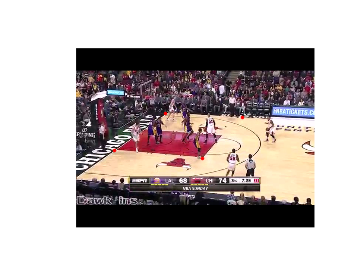

In [12]:
num = 200
image = vid.get_data(num)
fig, ax1 = plt.subplots()
padded_image = pad(image,((60,60),(0,0),(0,0)),'constant')
ax1.imshow(padded_image)
ax1.plot(interped[num][:, 0], interped[num][:, 1], '.r')
ax1.axis('off')

In [13]:
new_img, rects = predict(padded_image)

In [15]:
lines[num]

(array([ 103.5      ,    1.6137023], dtype=float32),
 array([ 231.       ,    0.9529497], dtype=float32),
 array([ 376.5       ,    0.77667153], dtype=float32),
 array([ 162.        ,    1.65806282], dtype=float32))

In [36]:
temp_img = court.put_lines_on_img(padded_image,lines[num][:2],y_shift=60)
temp2_img = court.put_lines_on_img(temp_img,lines[num][2:],y_shift=100)

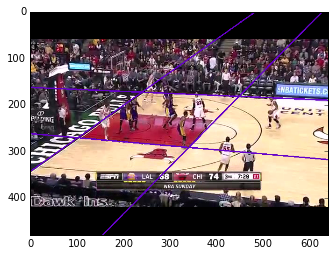

In [37]:
plt.imshow(temp2_img)

In [29]:
xs, ys, boxes = pred.get_box_coordinates(rects, conf=.2)
homography = court_warp.get_homography(interped[num])
xst, yst = court_warp.video_to_court(xs,ys,homography)
team_color = pred.team_classify(padded_image,boxes)
m_boxes, m_xst, m_yst, m_team_color = pred.mask_by_color(boxes,xst,yst,team_color)

In [30]:
m_boxes, m_xst, m_yst, m_team_color = pred.mask_by_color(boxes,xst,yst,team_color)

In [31]:
print m_team_color
print team_color

[2, 2, 1, 2, 1, 1, 1, 1]
[2, 2, 1, 2, 1, 1, 1, -1, 1]


In [39]:
new_img = pred.add_rectangles(temp2_img,m_boxes)

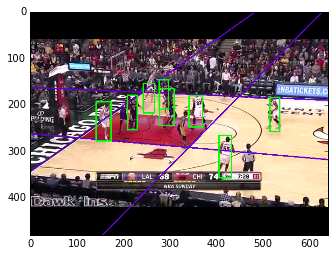

In [40]:
plt.imshow(new_img)

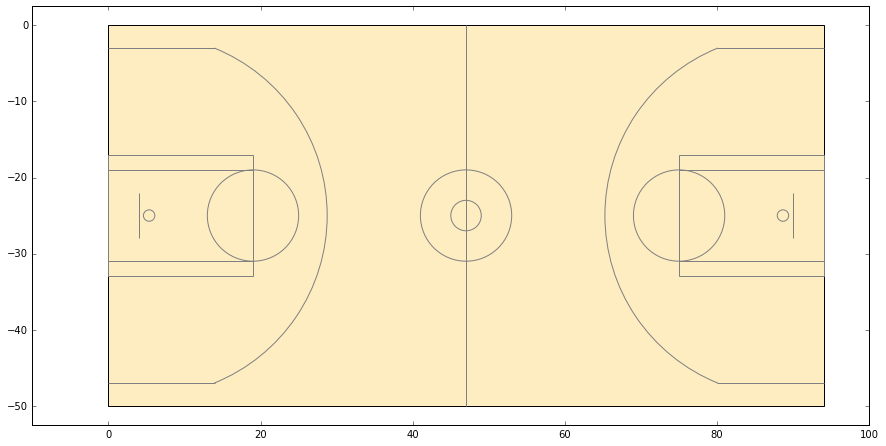

In [18]:
plt.figure(figsize=(15, 7.5))

# Plot the movemnts as scatter plot
# # using a colormap to show change in game clock
# color_dict = {-1:'yellow', 1:'white',2:'darkviolet',3:'dodgerblue'}
# color_map = [color_dict[team] for team in m_team_color]
# plt.scatter(inches_to_feet(m_xst), inches_to_feet(m_yst,y=True), c=color_map, s=1000, zorder=1)
# # Darker colors represent moments earlier on in the game
# #cbar = plt.colorbar(orientation="horizontal")
# # invert the colorbar to have higher numbers on the left
# #cbar.ax.invert_xaxis()
# 
draw_court()

plt.axis('equal')
plt.xlim(-10, 100)
plt.ylim(-60, 10)
plt.show()

In [42]:
from skimage import transform as transf

In [47]:
%matplotlib qt


In [49]:
margins = dict(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)

# text = pad(image,((60,60),(0,0),(0,0)),'constant')
text = temp2_img

CONSTANT = 0
src = np.array((
    (0, 0+CONSTANT),
    (228, 0+CONSTANT),
    (228, 396+CONSTANT),
    (0, 396+CONSTANT)
))


dst = interped[num]

tform3 = transf.ProjectiveTransform()
tform3.estimate(src, dst)
warped = transf.warp(new_img, tform3,output_shape=(600,1128))
tform3.params


# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))
# fig.subplots_adjust(**margins)
plt.gray()
# plt.imshow(text)
# plt.plot(dst[:, 0], dst[:, 1], '.r')
# plt.axis('off')
plt.imshow(warped)
plt.axis('off')

(-0.5, 1127.5, 599.5, -0.5)

(-0.5, 1127.5, 599.5, -0.5)

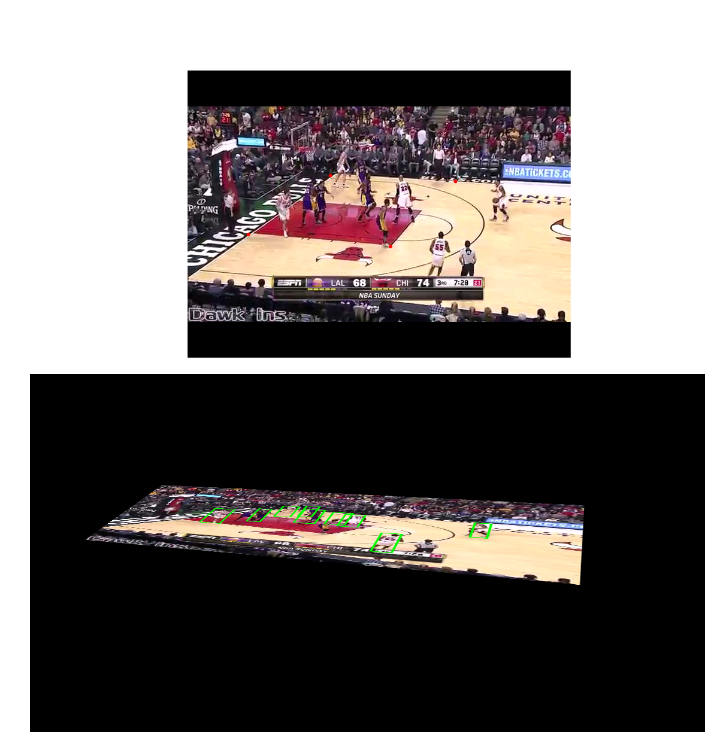

In [23]:
%matplotlib inline
margins = dict(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)

text = pad(image,((60,60),(0,0),(0,0)),'constant')

CONSTANT = 0
src = np.array((
    (0, 0+CONSTANT),
    (228, 0+CONSTANT),
    (228, 396+CONSTANT),
    (0, 396+CONSTANT)
))


dst = interped[num]

tform3 = transf.ProjectiveTransform()
tform3.estimate(dst, src)
warped = transf.warp(new_img, tform3,output_shape=(600,1128))
tform3.params


fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))
fig.subplots_adjust(**margins)
plt.gray()
ax1.imshow(text)
ax1.plot(dst[:, 0], dst[:, 1], '.r')
ax1.axis('off')
ax2.imshow(warped)
ax2.axis('off')

# Creating a Demo

In [113]:
filename = 'data/derrick.mp4'
vid = imageio.get_reader(filename, 'ffmpeg')

In [53]:
total_frames = 0
try:
    for _ in vid:
        total_frames += 1
except:
    pass
finally:
    print total_frames

349


In [59]:
%matplotlib qt

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
unpadded = vid.get_data(0)
new_im, _ = predict(pad(unpadded,((60,60),(0,0),(0,0)),'constant'))
im = ax.imshow(new_im,cmap='gray',interpolation='nearest')
im.set_clim([0,1])
fig.set_size_inches([5,5])


tight_layout()


def update_img(n):
    tmp, _ = predict(pad(vid.get_data(n),((60,60),(0,0),(0,0)),'constant'))
    im.set_data(tmp)
    return im

#legend(loc=0)
ani = animation.FuncAnimation(fig,update_img,total_frames,interval=30)
plt.show()

In [115]:
dpi = 100

def ani_frame(video):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    unpadded = video.get_data(0)
    new_im, _ = predict(pad(unpadded,((60,60),(0,0),(0,0)),'constant'))
    im = ax.imshow(new_im,cmap='gray',interpolation='nearest')
    im.set_clim([0,1])
    fig.set_size_inches([5,5])


    tight_layout()


    def update_img(n):
        tmp, _ = predict(pad(video.get_data(n),((60,60),(0,0),(0,0)),'constant'))
        im.set_data(tmp)
        return im

    #legend(loc=0)
    ani = animation.FuncAnimation(fig,update_img,total_frames,interval=30)
    writer = animation.writers['ffmpeg'](fps=30)

    ani.save('demolstm.mp4',writer=writer,dpi=dpi)
    return ani

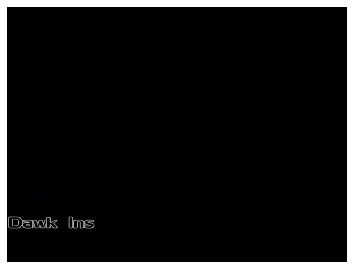

In [116]:
test = ani_frame(vid)

# FRAME INTERPOLATION

In [15]:
all_boxes = []
all_xs = []
all_ys = []
all_xst = []
all_yst = []
all_team_color = []

for i in range(total_frames):
    padded_image = pad(vid.get_data(i),((60,60),(0,0),(0,0)),'constant')
    _, rects = predict(padded_image)
    xs, ys, boxes = pred.get_box_coordinates(rects, conf=.3)
    homography = court_warp.get_homography(interped[0])
    xst, yst = court_warp.video_to_court(xs,ys,homography)
    team_color = pred.team_classify(padded_image, boxes)
#     m_boxes, m_xst, m_yst, m_team_color = pred.mask_by_color(boxes,xst,yst,team_color)
    all_boxes.append(boxes)
    all_xs.append(xs)
    all_ys.append(ys)
    all_xst.append(xst)
    all_yst.append(yst)
    all_team_color.append(all_team_color)
    

In [2]:
import scipy.spatial.distance as dst

In [ ]:
dst.euclidean(a,b)

In [ ]:
def pair_distances(xs1, ys1, xs2, ys2):
    t1 = zip(xs1, ys1)
    t2 = zip(xs2, ys2)

In [24]:
test1 = zip(all_xs[0],all_ys[0])

In [25]:
test2 = zip(all_xs[1],all_ys[1])

In [1]:
a = [302.0, 211.0, 223.0, 295.0, 381.0, 507.0, 128.0, 507.0]
b = [171.5, 283.5, 259.0, 215.5, 245.5, 258.5, 329.0, 234.0]

In [ ]:
class player:
    def __init__(self, xc, yb, box):
        self.x_center = xc
        self.y_bottom = yb
        self.box = box
        

In [29]:
%matplotlib inline

In [14]:
reload(pred)

<module 'predict' from 'predict.py'>

(-16.0, 110.0, -70.0, 20.0)

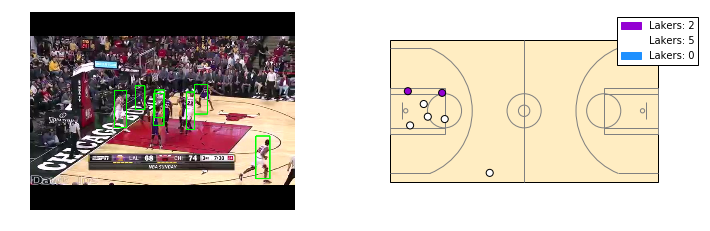

In [185]:
padded_image = pad(vid.get_data(125),((60,60),(0,0),(0,0)),'constant')
tmp, rects = predict(padded_image)
xs, ys, boxes = pred.get_box_coordinates(rects, conf=.3)
homography = court_warp.get_homography(interped[0])
xst, yst = court_warp.video_to_court(xs,ys,homography)
team_color = pred.team_classify(padded_image, boxes)
m_boxes, m_xst, m_yst, m_team_color = pred.mask_by_color(boxes,xst,yst,team_color)
masked_image = pred.add_rectangles(padded_image,m_boxes)

color_dict = {-1:'yellow', 1:'white',2:'darkviolet',3:'dodgerblue'}
color_map = [color_dict[team] for team in m_team_color]

# fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 15))
margins = dict(hspace=5.2, wspace=0.01, top=1, bottom=0, left=0, right=1)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 2.75))
fig.subplots_adjust(**margins)
anim_vid = ax1.imshow(masked_image)
scat = ax2.scatter(inches_to_feet(m_xst), inches_to_feet(m_yst,y=True), c=color_map, s=50, zorder=1)

lakers = Circle((5.35,-25), radius=.75,color=color_dict[2], label='Lakers: {}'.format(m_team_color.count(2)))
bulls = Circle((5.35,-25), radius=.75,color=color_dict[1], label='Lakers: {}'.format(m_team_color.count(1)))
mixed = Circle((5.35,-25), radius=.75,color=color_dict[3], label='Lakers: {}'.format(m_team_color.count(3)))

plots = [anim_vid,scat]
ax1.axis('off')
ax2 = draw_court()
ax2.axis('equal')
ax2.legend(handles = [lakers,bulls,mixed], fontsize=10)
ax2.set_xlim([-16, 110])
ax2.set_ylim([-70, 20])
ax2.axis('off')

In [174]:
boxes

[(274.5, 146.0, 299.5, 208.0),
 (153.5, 191.0, 182.5, 271.0),
 (235.0, 146.0, 253.0, 210.0),
 (275.5, 140.0, 296.5, 190.0),
 (346.5, 168.0, 383.5, 238.0),
 (333.5, 184.5, 364.5, 251.5),
 (204.0, 178.5, 230.0, 253.5),
 (504.0, 180.5, 536.0, 249.5),
 (406.5, 260.5, 431.5, 339.5),
 (317.0, 178.0, 333.0, 238.0)]

In [178]:
padded_image = pad(vid.get_data(200),((60,60),(0,0),(0,0)),'constant')

In [179]:
box_image = pred.add_rectangles(padded_image,boxes)

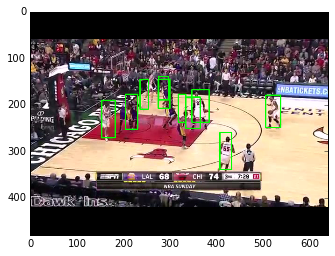

In [180]:
plt.imshow(box_image)